<a href="https://colab.research.google.com/github/Abhishek-Mandapmalvi/MPC-Project/blob/main/Phase_2_MPC_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from numpy.linalg import inv
from jax.typing import ArrayLike
import matplotlib.pyplot as plt
import imageio
from IPython import display
from google.colab import files
from matplotlib.patches import Ellipse
import random
import cvxpy as cp
import math

# Initial Condition

In [2]:
# Conversion factor from radians to degrees
rad2deg = 180.0 / np.pi

# Conversion factor from degrees to radians
deg2rad = np.pi / 180.0

# Time step for simulation
dt = 0.1

n = 4   # state dim
m = 2   # control dim

L = 1.0 # length of car"
Q = jnp.diag(jnp.array([1., 1., 0., 1.]))
Qt = jnp.diag(jnp.array([1., 1., 0., 1.]))
R = jnp.diag(jnp.array([1., 1.]))

Sigma_vec = np.array([0.0, 0.0, 0.0, 0.0])
np.random.seed(seed=123)
noise_vec = np.random.randn(n) * Sigma_vec

a_max = 100.  # maximum control magnitude
steer_max = 30.0*deg2rad
a_min = -100.  # maximum control magnitude
steer_min = -30.0*deg2rad

N_MPC_horizon = 10
N_total_horizon = 200

## Reference Traj

Text(0.5, 1.0, 'Target Trajectory Waypoints (x,y)')

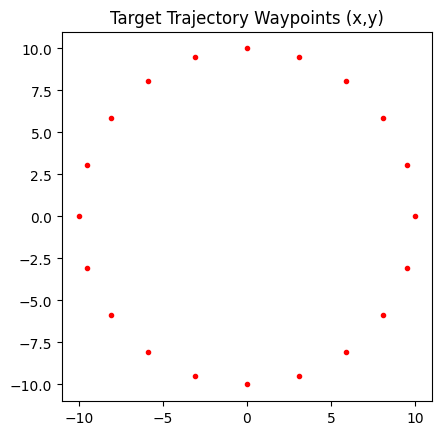

In [3]:
Number_of_planned_points_in_time = 20
Total_Traj_Length = 0.0

trajX = jnp.zeros(Number_of_planned_points_in_time)         # trajX  is skeleton for X values
trajY = jnp.zeros(Number_of_planned_points_in_time)         # trajY  is skeleton for Y values
trajTheta = jnp.zeros(Number_of_planned_points_in_time) ## trajTheta is skeleton for Theta values
End_point = Number_of_planned_points_in_time * dt        # End point
Target_traj_in_time = jnp.arange(0.0,End_point,dt)       # Time stamp for target trajectory

for time_instance in range(len(Target_traj_in_time)):
  trajX = trajX.at[time_instance].set(10*jnp.cos((2.0*np.pi/End_point)*Target_traj_in_time[time_instance]))
  trajY = trajY.at[time_instance].set(10*jnp.sin((2.0*np.pi/End_point)*Target_traj_in_time[time_instance]))

trajTheta = np.ones_like(trajX)*90.*deg2rad
trajv = np.ones_like(trajX)*1

Target = jnp.stack([trajX,trajY,trajTheta,trajv],1)
plt.figure()
plt.plot(trajX,trajY,'r.')
plt.axis('square'); # Use for circle traj
plt.title('Target Trajectory Waypoints (x,y)')

# Kinematics

In [4]:
def continuous_time_unicycle_dynamics(state: ArrayLike, control: ArrayLike) -> ArrayLike:
  x,y,theta,v = state
  omega, a = control
  
  xd = v * jnp.cos(theta)
  yd = v * jnp.sin(theta)
  thetad = omega
  vd = a
  
  return jnp.array([xd, yd, thetad, vd])

In [5]:
def unicycle_dynamics_noise(state, control, noise_vec, dt):
  x,y,theta,v = state
  delta, a = control
  xn,yn,thetan,vn = noise_vec
  
  xd = x + v * jnp.cos(theta)*dt
  yd = y + v * jnp.sin(theta)*dt
  thetad = theta + (v) * np.tan(delta) * dt
  vd = v + a*dt
  
  return jnp.array([xd, yd, thetad, vd])

# Linearization

In [6]:
def linearize_dynamics_autodifferentiation(dynamics_func, state0: ArrayLike, control0: ArrayLike) -> tuple:
  
  A = jax.jacobian(dynamics_func,argnums=0)(state0,control0)
  B = jax.jacobian(dynamics_func,argnums=1)(state0,control0)
  C = dynamics_func(state0, control0) - A @ state0 - B @ control0
  C = jnp.round(C,decimals=8)
  
  return A, B, C

# CVXPY

In [7]:
# set up trajectory optimization problem but with initial state as a parameter that can be updated
def setup_trajopt(Q, R, Qt, goal, angle_max, angle_min, acc_max, acc_min, MPC_horizon, dt):
    n = 4
    m = 2

    xs = cp.Variable([n, MPC_horizon+1], name="states")
    u = cp.Variable([m,MPC_horizon], name="control")
    
    # initial state is a parameter. It can be updated before solving the problem
    initial_state = cp.Parameter(n, name="initial_state")
    
    objective = 0.0
    constraints = []
    A,B,C = linearize_dynamics_autodifferentiation(continuous_time_unicycle_dynamics,goal,jnp.array([90.*deg2rad,10.]))
    
    for t in range(MPC_horizon):
      objective += cp.quad_form((xs[:,t] - goal), Q) + cp.quad_form(u[:,t], R)
      constraints += [xs[:, t + 1] ==  xs[:, t] + A @ xs[:, t] + B @ u[:, t] + C, u[0, t] <= angle_max, u[0, t] >= angle_min, u[1, t] <= acc_max, u[1, t] >= acc_min]
      
    objective += cp.quad_form(xs[:,MPC_horizon]-goal, Qt)  # Terminal state cost
    constraints += [xs[:,0] == initial_state]  # Initial state constraint
    
    problem = cp.Problem(cp.Minimize(objective), constraints)
    return problem

# function to update the value of initial_state
def update_initial_state(problem, initial_state):
    problem.param_dict["initial_state"].project_and_assign(initial_state)
    return problem

# Target Update

In [8]:
def calculate_distance(point1, point2):
    x1, y1 = point1[:2]  # Extract x, y coordinates from point1
    x2, y2 = point2[:2]  # Extract x, y coordinates from point2

    # Calculate the Euclidean distance between the two points
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

# Output

<ipython-input-9-633f24074b2f>:73: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(path) for path in image_paths]


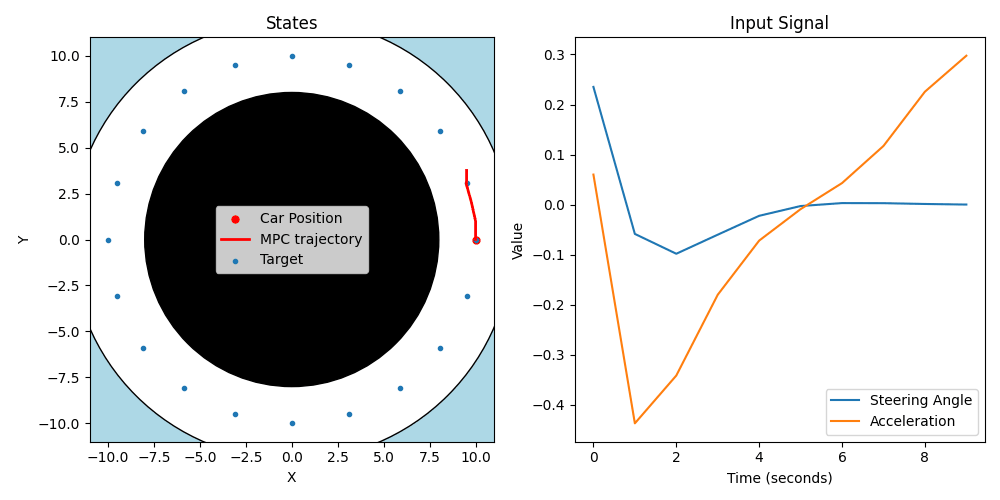

In [9]:
MPC_states = np.zeros((N_total_horizon+1, n))
MPC_controls = np.zeros((N_total_horizon, m))
current_state = Target[0]
pt = 1
target_pt = Target[pt]

image_paths = []

for i in range(N_total_horizon):
    problem = setup_trajopt(Q, R, Qt, target_pt, steer_max, steer_min, a_max, a_min, N_MPC_horizon, dt)
    problem = update_initial_state(problem, current_state)
    problem.solve()

    MPC_states[i, :] = problem.variables()[0].value[:, 0]
    MPC_controls[i, :] = problem.variables()[1].value[:, 0]

    current_state = unicycle_dynamics_noise(problem.variables()[0].value[:,0], problem.variables()[1].value[:,0], noise_vec, dt)
    
    distance = calculate_distance(problem.variables()[0].value[:, 0], target_pt)

    if distance <= 2:
        pt += 1
        target_pt = Target[pt]

    if pt == len(Target):
        break

    states = problem.variables()[0].value
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].set_facecolor('lightblue')
    ax[0].set_aspect(1)

    outer_circle = plt.Circle((0.0, 0.0), 12.0, facecolor='White', edgecolor='black')
    inner_circle = plt.Circle((0.0, 0.0), 8.0, facecolor='black', edgecolor='black')

    ax[0].add_artist(outer_circle)
    ax[0].add_artist(inner_circle)
        
    ax[0].scatter(MPC_states[i, 0], MPC_states[i, 1], label="Car Position", color="r", marker='.', s=100)
    ax[0].plot(states[0,:], states[1,:], label="MPC trajectory", color="r", linewidth=2)
    ax[0].scatter(Target[:, 0], Target[:, 1], label="Target", marker='.')

    ax[0].set_xlabel('X')
    ax[0].set_ylabel('Y')
    ax[0].set_title('States')

    data = problem.variables()[1].value
    time = range(N_MPC_horizon)  # Fixed time value

    # Plot the first two columns of 'data' against the fixed time value
    ax[1].plot(time, data[0], label="Steering Angle")
    ax[1].plot(time, data[1], label="Acceleration")

    # Set labels and title
    ax[1].set_xlabel('Time (seconds)')
    ax[1].set_ylabel('Value')
    ax[1].set_title('Input Signal')

    # Add a legend
    ax[0].legend()
    ax[1].legend()

    plt.tight_layout()
    # Save the plot as an image
    image_path = f"plot_{i}.png"
    plt.savefig(image_path)
    image_paths.append(image_path)

    plt.close(fig)

# Create a GIF from the saved plot images
gif_path = "output.gif"
images = [imageio.imread(path) for path in image_paths]
imageio.mimsave(gif_path, images, duration=0.01)  # Adjust duration as needed

from IPython.display import Image, display

# Display the GIF
display(Image(filename='output.gif'))